# Boundary Integral Method Final Project: Internal Dirichlet Problem

## Department of Engineering Science and Ocean Engineering
## National Taiwan University
### R09525090 Daniel Lam

This project purpose is to solve the potential flow around arbitrary airfoils using the boundary integral equation formulation, with a Kutta condition applied at the trailing edge of the airfoil. We first start the project by solving first with panel methods, based on source and doublet elements. In addition, problems based on Neumann and Dirichlet boundary conditions will be solved in this project. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import interpolate
from math import log, cos, sin, atan2, acos, sqrt
pi = np.pi
np.set_printoptions(precision=3)

# Helper Functions

Some functions that will be used during the project, but their purpose is more for either obtaining data or the visualization of the results:

1. readAirfoilData
2. processDat
3. plotAirfoil

In [2]:
def ReadAirfoilDat( airfoilName ):
    currentDir = os.path.abspath(os.getcwd())
    filepath = currentDir + "/" + airfoilName + ".dat"
    print( filepath )
    if os.path.exists(filepath):
        f = open(filepath, "r")
        airfoilDat = f.read()
        f.close()
        return airfoilDat
    else:
        print("The file does not exist")
        
def ProcessDat( airfoilDat ):
    airfoilDat = (" ".join(airfoilDat.split())).split()
    N = len(airfoilDat)
    x = []
    y = []
    for i in range( 0, N, 2 ):
        x.append( float( airfoilDat[i] ) )
        y.append( float( airfoilDat[i+1] ) )
    id = y.index(max( y ))
    displacement = x[id]
    i = 0
    for xx in x:
        x[i] = x[i] - displacement
        i = i + 1    
    
    x = np.asarray(x)
    y = np.asarray(y)
    x = x.astype(np.float)
    y = y.astype(np.float)
    return x, y

def PlotAirfoil( N, airfoilName ):
    airfoilDat = ReadAirfoilDat( airfoilName )
    X, Y = ProcessDat( airfoilDat )
    tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    C = computeChordLength( X )
    T = computeAirfoilPseudoThickness( Y )
    
#     t, w = gaussLegendreParameter( N )
#     x, y = computeGaussNodeLocations( t, tck )

    
    
    fig, ax = plt.subplots(figsize=(16, 32*T/C))
    plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
    plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
    plt.minorticks_on()
    plt.xlabel(xlabel='x', fontsize=16)
    plt.ylabel(ylabel='y', fontsize=16)
    D = .75 * C
    ax.set_xlim([-D+np.mean(X), D+np.mean(X)])
    ax.set_ylim([-D*T/C, D*T/C])
    plt.title( airfoilName + " Geometry", fontsize=20)
#     plt.plot( X, Y, '*', label="Original Geometry")
    plt.plot( x, y, '--*', label="B-spline Representation")
    plt.legend()
#     xc, yc = computeCollocationNodeLocations( N+1, tck )
#     plt.plot( xc, yc, '*', markersize=10)
    
    

/Users/daniellam/Google Drive/python/2020to2021/Numerical Partial Differential Equations/Boundary Integral Method/OLDBoundary Element Method/NACA0006.dat


/var/folders/w4/k77mbt9n39g5b878kkzr9wmc0000gn/T/ipykernel_14006/1196209119.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
/var/folders/w4/k77mbt9n39g5b878kkzr9wmc0000gn/T/ipykernel_14006/1196209119.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.float)


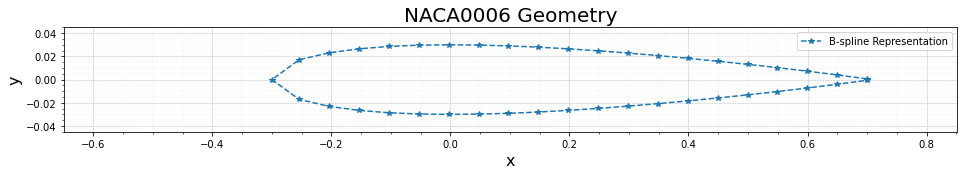

In [5]:
N = 40
airfoilName = "NACA0006"

PlotAirfoil( N, airfoilName )

# Geometry

The discretization of the geometry is the first step of the problem. For this we employ Python's numerical library Scipy to describe the airfoil geometry through splines. In general, the geometry of the airfoil will be described by a parameterized curve, with parameter $t = [0, 1]$, where $t = 0$ is the parameter value when the point is on the upper trailing edge, and $t = 1$ for the lower trailing edge. 

This library also allows us to obtain the derivatives of the curve, in order to obtain either the vector tangent or normal to the curve. Since a curve can have "two" normals on a point, i.e., one points outward of the curve, the other one points inward, we must correct this behavior by using the cross product of the tangent vector and the normal curve, such that only the cross product of the tangent vector and the normal vector $ t \times n $ is either always negative or positive.

The only requirement for the points of the 2D airfoil is that the points start from the upper trailing edge, and then go to the lower trailing edge, otherwise, the behaviour of the program is not guaranteed to be correct.

In [6]:
def createPeriodicSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0, per=1)
    return tck

def createSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0 )
    return tck

def computeNodeLocations( N, tck ):
    t = np.linspace( 0, 1, N )
    x, y = interpolate.splev(t, tck)
    return x, y

def computeCollocationNodeLocations( N, tck ):
    t = np.linspace( 0, 1, N )
    t = .5*( t[:-1] + t[1:] )
    x, y = interpolate.splev(t, tck)
    return x, y

def computeNormParameterizationDerivative( N, tck ):
    t = np.linspace( 0, 1, N )
    dx_dt, dy_dt = interpolate.splev(t, tck, der=1)
    ds_dt = np.sqrt( dx_dt**2 + dy_dt**2 )
    return ds_dt

## this function I think is unnecessary but not sure
def computeRadial( N, tck ):
    t = np.linspace( 0, 1, N )
    rx, ry = interpolate.splev(t, tck)
    norm = np.sqrt( rx**2 + ry**2 )
    return rx/norm, ry/norm

def computeTangent( N, tck ):
    t = np.linspace( 0, 1, N )
    tx, ty = interpolate.splev(t, tck, der=1)
    norm = np.sqrt( tx**2 + ty**2 )
    return tx/norm, ty/norm

def computeNormal( N, tck ):
    t = np.linspace( 0, 1, N )
    nx, ny = interpolate.splev(t, tck, der=2)
    norm = -np.sqrt( nx**2 + ny**2 )
    return nx/norm, ny/norm

def computeBinormal( N, tck ):
    tx, ty = computeTangent( N, tck )
    nx, ny = computeNormal( N, tck )
    tangentVector = np.vstack( (tx, ty) )
    normalVector = np.vstack( (nx, ny) )
    binormal = np.cross( np.transpose(tangentVector), np.transpose(normalVector) )
    return -binormal

def computeCurvature( N, tck ):
    t = np.linspace( 0, 1, N )
    d1x, d1y = interpolate.splev(t, tck, der=1)
    d2x, d2y = interpolate.splev(t, tck, der=2)
    curvature = (d2x*d1y - d2y*d1x) / (d1x**2+d1y**2)**(3/2)
    return curvature

def computeChordLength( X ):
    return np.max(X) - np.min(X)

def computeAirfoilPseudoThickness( Y ):
    return np.max(Y) - np.min(Y)

def createWakeGeometry( X, Y, AOA ):
    chordLength = computeChordLength( X )
    wakeLength = 1000 * chordLength
    x0 = .5 * ( X[0] + X[-1] )
    y0 = .5 * ( Y[0] + Y[-1] )
    xf = x0 + wakeLength * np.cos( AOA * pi/180 )
    yf = y0 + wakeLength * np.sin( AOA * pi/180 )
    Xw = np.asarray( [x0, xf] )
    Yw = np.asarray( [y0, yf] )
    tck, u = interpolate.splprep([Xw, Yw], k=1, s=0, quiet=True )
    return tck

def computeWakeNormal( Nw, AOA ):
    nxw = -np.sin( AOA * pi/180 ) * np.ones( Nw )
    nyw = np.cos( AOA * pi/180 ) * np.ones( Nw )
    return nxw, nyw

def ComputeAlpha( x1, y1, x2, y2 ):
    return atan2( -(y1-y2), -(x1-x2) )

def GlobalToPanelCoords( x, y, x1, y1, x2, y2 ):
    alpha = ComputeAlpha( x1, y1, x2, y2 )
    
    ## first displace all points such that the coordinate system origin is on (x1, y1)
    xp = cos(alpha) * ( x - x1 ) + sin(alpha) * ( y - y1 )
    yp = -sin(alpha) * ( x - x1 ) + cos(alpha) * ( y - y1 )
    xp1 = 0 
    yp1 = 0 
    xp2 = cos(alpha) * ( x2 - x1 ) + sin(alpha) * ( y2 - y1 )
    yp2 = -sin(alpha) * ( x2 - x1 ) + cos(alpha) * ( y2 - y1 )
    
    return xp, yp, xp1, yp1, xp2, yp2, alpha

def gaussLegendreParameter( N ):
    t, w = np.polynomial.legendre.leggauss( N )
    t1 = .25 + .25*t
    w1 = .25 * w
    t2 = .75 + .25*t
    w2 = w1
    t = np.concatenate( ( t1, t2 ) )
    w = np.concatenate( ( w1, w2 ) )
    return t, w

def createPeriodicSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0, per=1)
    return tck

def createSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0 )
    return tck

def computeGaussNodeLocations( t, tck ):
    x, y = interpolate.splev(t, tck)
    return x, y

def computeGaussNormParameterizationDerivative( t, tck ):
    dx_dt, dy_dt = interpolate.splev(t, tck, der=1)
    ds_dt = np.sqrt( dx_dt**2 + dy_dt**2 )
    return ds_dt


def computeGaussTangent( t, tck ):
    tx, ty = interpolate.splev(t, tck, der=1)
    norm = np.sqrt( tx**2 + ty**2 )
    return tx/norm, ty/norm

def computeGaussNormal( t, tck ):
    nx, ny = interpolate.splev(t, tck, der=2)
    norm = -np.sqrt( nx**2 + ny**2 )
    return nx/norm, ny/norm

def computeGaussBinormal( t, tck ):
    tx, ty = computeGaussTangent( t, tck )
    nx, ny = computeGaussNormal( t, tck )
    tangentVector = np.vstack( (tx, ty) )
    normalVector = np.vstack( (nx, ny) )
    binormal = np.cross( np.transpose(tangentVector), np.transpose(normalVector) )
    return -binormal

def computeGaussCurvature( t, tck ):
    d1x, d1y = interpolate.splev(t, tck, der=1)
    d2x, d2y = interpolate.splev(t, tck, der=2)
    curvature = (d2x*d1y - d2y*d1x) / (d1x**2+d1y**2)**(3/2)
    return curvature

def computeChordLength( X ):
    return np.max(X) - np.min(X)

def computeAirfoilPseudoThickness( Y ):
    return np.max(Y) - np.min(Y)

def createWakeGeometry( X, Y, AOA ):
    chordLength = computeChordLength( X )
    wakeLength = 1000 * chordLength
    x0 = .5 * ( X[0] + X[-1] )
    y0 = .5 * ( Y[0] + Y[-1] )
    xf = x0 + wakeLength * np.cos( AOA * pi/180 )
    yf = y0 + wakeLength * np.sin( AOA * pi/180 )
    Xw = np.asarray( [x0, xf] )
    Yw = np.asarray( [y0, yf] )
    tck, u = interpolate.splprep([Xw, Yw], k=1, s=0, quiet=True )
    return tck

def computeWakeNormal( Nw, AOA ):
    nxw = -np.sin( AOA * pi/180 ) * np.ones( Nw )
    nyw = np.cos( AOA * pi/180 ) * np.ones( Nw )
    return nxw, nyw

def ComputeAlpha( x1, y1, x2, y2 ):
    return atan2( -(y1-y2), -(x1-x2) )

def GlobalToPanelCoords( x, y, x1, y1, x2, y2 ):
    alpha = ComputeAlpha( x1, y1, x2, y2 )
    
    ## first displace all points such that the coordinate system origin is on (x1, y1)
    xp = cos(alpha) * ( x - x1 ) + sin(alpha) * ( y - y1 )
    yp = -sin(alpha) * ( x - x1 ) + cos(alpha) * ( y - y1 )
    xp1 = 0 
    yp1 = 0 
    xp2 = cos(alpha) * ( x2 - x1 ) + sin(alpha) * ( y2 - y1 )
    yp2 = -sin(alpha) * ( x2 - x1 ) + cos(alpha) * ( y2 - y1 )
    
    return xp, yp, xp1, yp1, xp2, yp2, alpha
    
    

## Geometry Code Validation

To check that the code is working correctly, we employ various examples to check the correctness of the code and see there's not any issue with the expected behaviour of the program.

/Users/daniellam/Google Drive/python/2020to2021/Numerical Partial Differential Equations/Boundary Integral Method/OLDBoundary Element Method/NACA0006.dat


/var/folders/w4/k77mbt9n39g5b878kkzr9wmc0000gn/T/ipykernel_14006/1196209119.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
/var/folders/w4/k77mbt9n39g5b878kkzr9wmc0000gn/T/ipykernel_14006/1196209119.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.float)


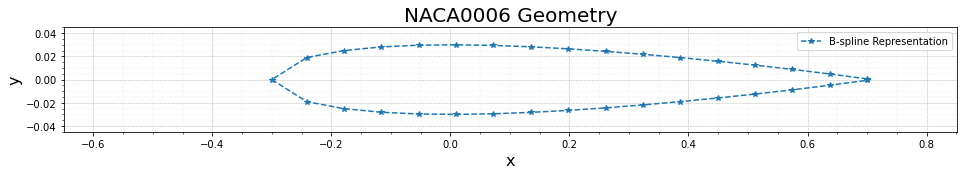

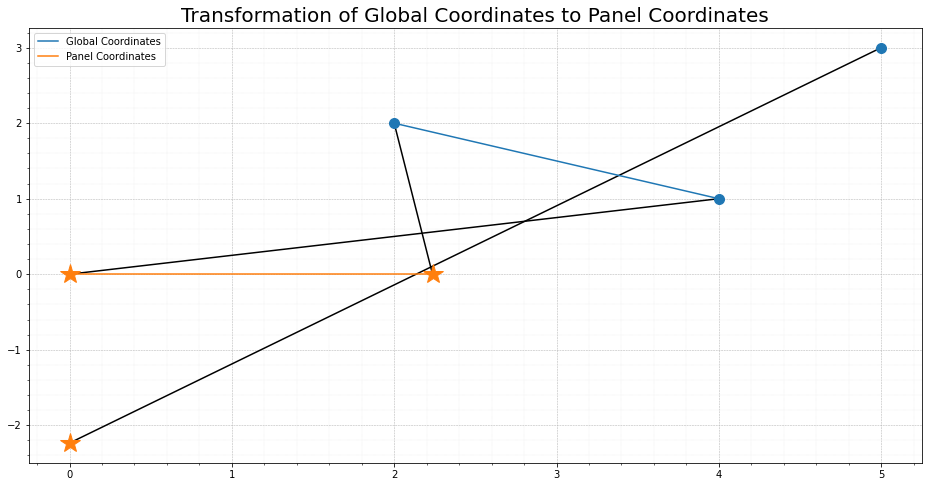

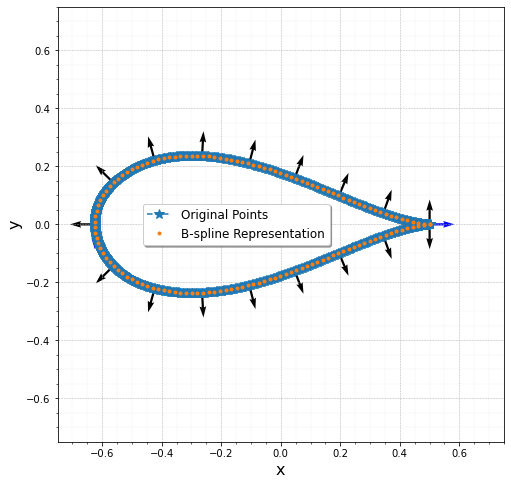

In [7]:
%run geometryCodeValidation.ipynb

In [8]:
def PHICD( x, y, x1, y1, x2, y2 ):
    ## transform from global coordinates to panel coordinates (coordinates)
    xp, yp, xp1, yp1, xp2, yp2, alpha = GlobalToPanelCoords( x, y, x1, y1, x2, y2 )
    
    ## compute induced velocity potential by the doublet element (in panel coordinates)
    th1 = atan2( yp, xp-xp1 ); th2 = atan2( yp, xp-xp2 )
    phi = -( th2 - th1 )/2/pi
    return phi 

def computeGreenNormal2D( x, y, xj, yj , normalx, normaly ):
    rj2 = (x - xj)**2 + (y - yj)**2
    dGdr = ( 1 / 2 / pi ) / rj2#**.5
    gradrn = normalx * (x - xj) + normaly * (y - yj)
    return -dGdr * gradrn

def gaussQuadReg( X, Y, N, U0, AOA ):
    ## check if the geometry has sharp trailing edge
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    t, w = gaussLegendreParameter( N )
    x, y = computeGaussNodeLocations( t, tck )
    theta = np.arctan2( y[:], x[:] )
    ds_dt = computeGaussNormParameterizationDerivative( t, tck )
    nx, ny = computeGaussNormal( t, tck )
    binormal = computeGaussBinormal( t, tck )
    curvature = computeGaussCurvature( t, tck )
    c = computeChordLength( X )
    

    ## correct normal direction
    nx = binormal * nx
    ny = binormal * ny
    
    
    ## generate system of equations
    A = np.zeros( (2*N+1, 2*N+1) )
    b = np.zeros( 2*N+1 )
    T = np.linspace(0, 1, 3)
    xh, yh = computeGaussNodeLocations( T, tck )
    
    ## matrix influence due to airfoil
    for i in range( 2*N ):
        b[i] = U0 * ( x[i] * cos( AOA * pi / 180 ) +  y[i] * sin( AOA * pi / 180 ) )
        k = 2*N-i-1
        ## add subtended angle
        l1t1 = (xh[0] - x[i])*(xh[1]-x[i]) + (yh[0]-y[i])*(yh[1]-y[i])
        l1t1 = l1t1 / ( sqrt((xh[0] - x[i])**2 + (yh[0]-y[i])**2) * ( sqrt((xh[1]-x[i])**2 + (yh[1]-y[i])**2) ) )
        I1 = acos( l1t1 )/pi/2
        A[i, k] = A[i, k] + I1
        A[i, i] = A[i, i] + (1 - I1)
        if i < N: ## c1
            for j in range( 2*N ):
                gij1 = computeGreenNormal2D( x[i], y[i], x[j], y[j], nx[j], ny[j]) * w[j] * ds_dt[j] 
                if j < N: ## same curve ## c1
                    if j != i:
                        A[i, i] = A[i, i] - gij1
                        A[i, j] = A[i, j] + gij1

                else: ## diff curve ## c2
                    if j != k:
                        A[i, k] = A[i, k] - gij1
                        A[i, j] = A[i, j] + gij1
  
        else: ## c2
            for j in range( 2*N ):
                gij1 = computeGreenNormal2D( x[i], y[i], x[j], y[j], nx[j], ny[j] ) * w[j] * ds_dt[j] 
                if j < N: ## diff curve ## c2
                    if j != k:
                        A[i, k] = A[i, k] - gij1
                        A[i, j] = A[i, j] + gij1
                    
                else: ## same curve ## c1
                    if j != i:
                        A[i, i] = A[i, i] - gij1
                        A[i, j] = A[i, j] + gij1
            
    ## matrix influence due to wake
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( 3, tckw )
    nxw, nyw = computeWakeNormal( 3, AOA )
    for i in range( 2*N ):
        aik = PHICD( x[i], y[i], xw[0], yw[0], xw[-1], yw[-1] )
        A[i, -1] = A[i, -1] - aik

    ## kutta condition
    A[-1, 0] = 1; A[-1, -2] = -1; A[-1, -1] = 1
    
    return A, b, x, y
            

/var/folders/w4/k77mbt9n39g5b878kkzr9wmc0000gn/T/ipykernel_14006/1548889053.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  dGdr = ( 1 / 2 / pi ) / rj2#**.5
/var/folders/w4/k77mbt9n39g5b878kkzr9wmc0000gn/T/ipykernel_14006/1548889053.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return -dGdr * gradrn
/var/folders/w4/k77mbt9n39g5b878kkzr9wmc0000gn/T/ipykernel_14006/1548889053.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  dGdr = ( 1 / 2 / pi ) / rj2#**.5
/var/folders/w4/k77mbt9n39g5b878kkzr9wmc0000gn/T/ipykernel_14006/1548889053.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return -dGdr * gradrn
/var/folders/w4/k77mbt9n39g5b878kkzr9wmc0000gn/T/ipykernel_14006/1548889053.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  dGdr = ( 1 / 2 / pi ) / rj2#**.5
/var/folders/w4/k77mbt9n39g5b878kkzr9wmc0000gn/T/ipykernel_14006/1548889053.py:14: RuntimeWarning: invalid value encountered in d

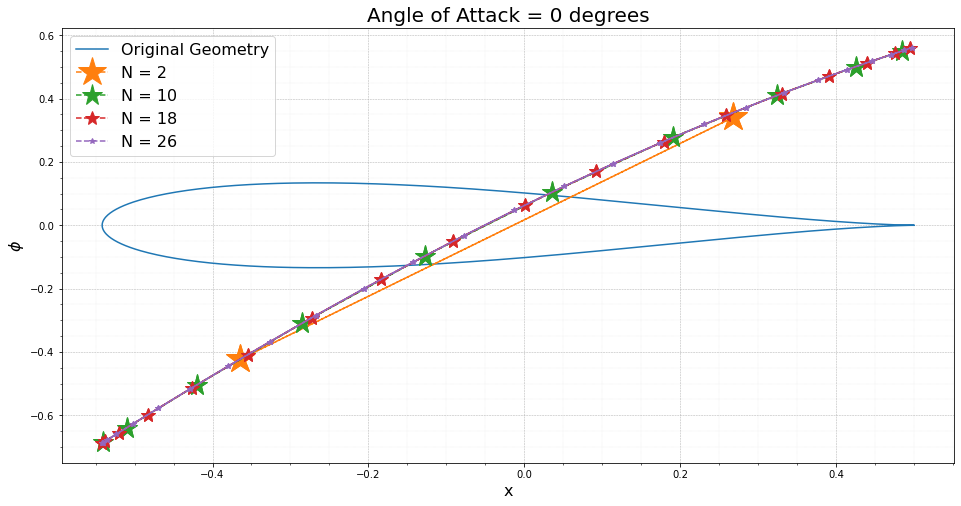

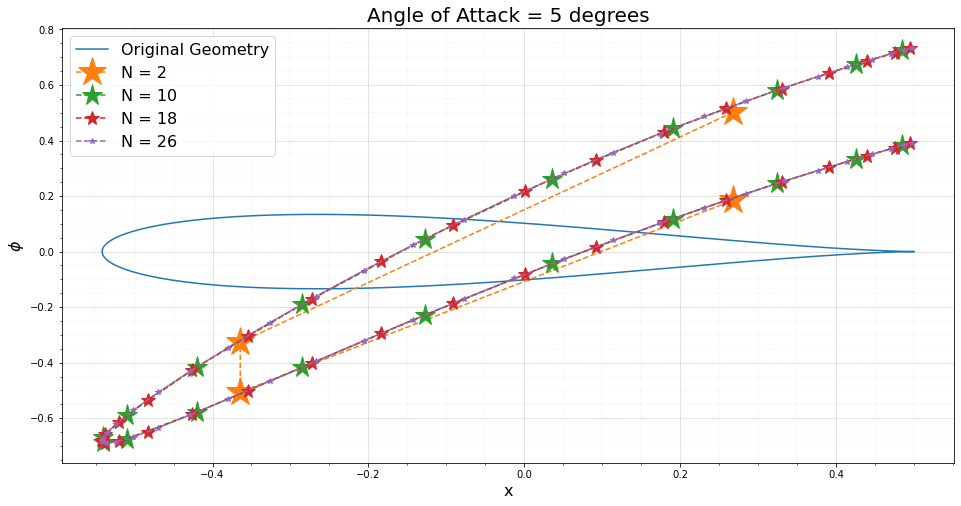

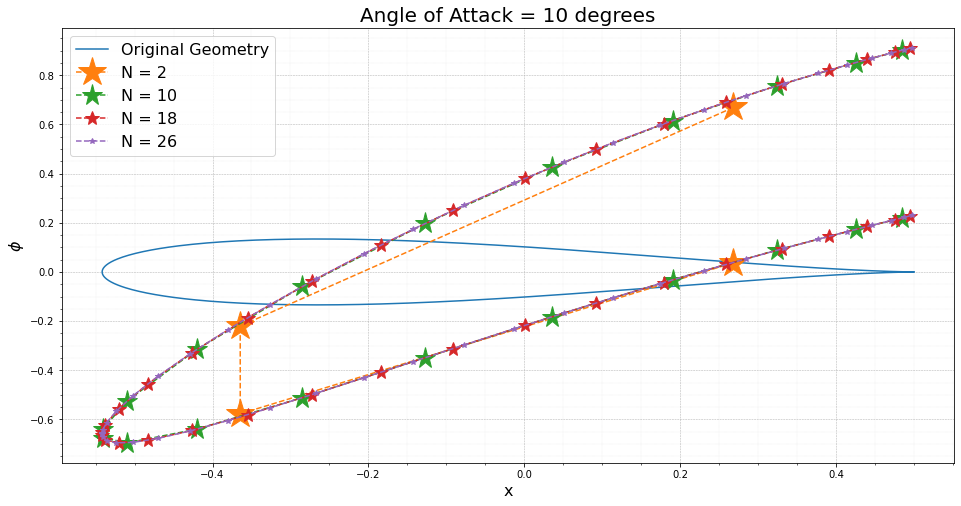

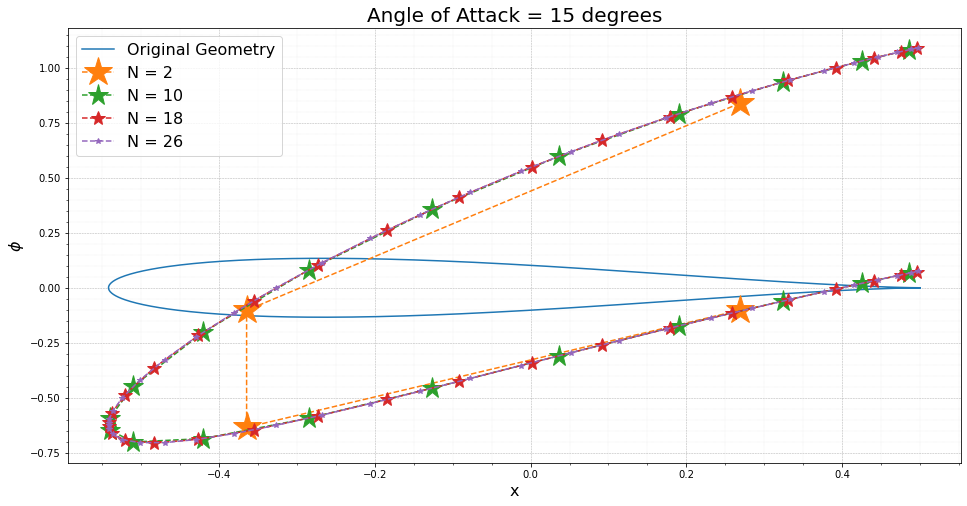

In [9]:
U0 = 1
M = 512
## create geometry
c = 1
e = 0.25
a = c * ( 1 + e ) / 4

t = np.linspace( 0, 1, M )
X0 = - e * c / 4
X = a * np.cos( 2 * pi * t ) + X0
Y = a * np.sin( 2 * pi * t )
Z = X + 1j*Y
Z = Z + c**2/Z/16
X = np.real(Z)
Y = np.imag(Z)

for AOA in range( 0, 16, 5):
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.title("Angle of Attack = " + str(AOA) +" degrees", fontsize=20)
    plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
    plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
    plt.minorticks_on()
    plt.xlabel(xlabel='x', fontsize=16)
    plt.ylabel(ylabel='$\phi$', fontsize=16)
    plt.plot( X, Y, label='Original Geometry' )




    for N in range( 4-2, 29-2, 8):

        A, b, x, y = gaussQuadReg( X, Y, N, U0, AOA )
        nu = np.linalg.solve( A, b )
        nu = nu[:-1]
        plt.plot( x, nu, '--*', markersize=32-N, label="N = " + str(N) )


    ax.legend(fontsize=16)



